# 1. Pickle - Load Trained Model,Use Model to Predict
the model.pkl below was trained in SageMaker and downloaded from S3

In [1]:
from pathlib import Path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cwd = Path.cwd()
trained_model_path = cwd / 'Trained_Model'
model_filename = 'model.pkl'
model_path_file = trained_model_path / model_filename

In [2]:
# load trained model
with open(model_path_file, 'rb') as f:
    regressor = pickle.load(f)
print(regressor)

LinearRegression()


In [3]:
dataset_path = cwd / 'Dataset'
dataset_filename = "FuelEconomy.csv"
dataset_path_file = dataset_path / dataset_filename
dataset_filetype = 'csv'

if dataset_filetype == 'csv':
    data = pd.read_csv(dataset_path_file)
else:
    raise SystemError("Dataset: Unknown File Type")

data.head(3)

,Horse Power,Fuel Economy (MPG)
0,118.770799,29.344195
1,176.326567,24.695934
2,219.262465,23.952010


In [4]:
X = data[['Horse Power']].values
y = data['Fuel Economy (MPG)'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [5]:
y_predict = regressor.predict(X_test)
y_predict

array([23.3269477 , 27.77028198, 22.00068701, 29.05736303, 24.26035635,
       20.91130092, 20.539707  , 17.74132024, 19.99136486, 22.52622477,
       26.84346244, 21.39643912, 23.83467756, 23.2796172 , 20.48809748,
       21.56760376, 25.11455063, 16.13451955, 19.04367867, 22.44234477,
       13.88684544, 16.90685794, 14.6955805 , 15.84154829, 20.89248501])

Text(0.5, 1.0, 'HP vs. MPG (Training dataset)')

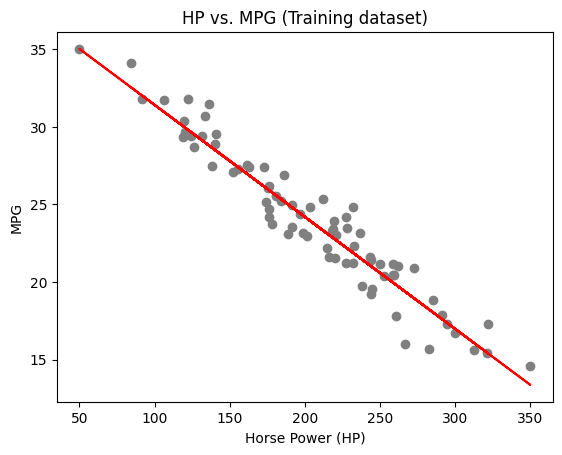

In [6]:
plt.scatter(X_train, y_train, color = 'gray')
plt.plot(X_train, regressor.predict(X_train), color = 'red')
plt.ylabel('MPG')
plt.xlabel('Horse Power (HP)')
plt.title('HP vs. MPG (Training dataset)')

Text(0.5, 1.0, 'HP vs. MPG (Testing dataset)')

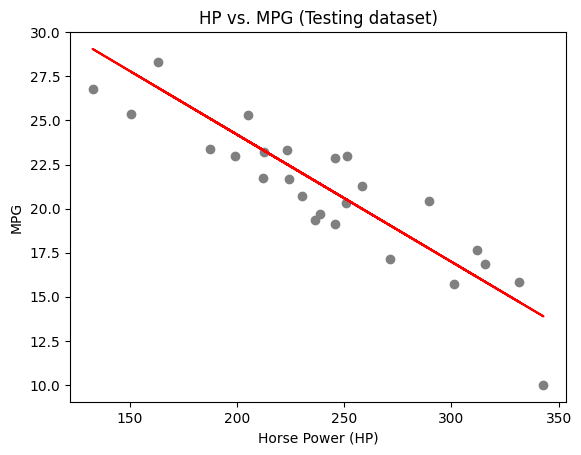

In [7]:
# VISUALIZE TEST SET RESULTS
plt.scatter(X_test, y_test, color = 'gray')
plt.plot(X_test, regressor.predict(X_test), color = 'red')
plt.ylabel('MPG')
plt.xlabel('Horse Power (HP)')
plt.title('HP vs. MPG (Testing dataset)')

In [8]:
HP = [[240]]
y_predict = regressor.predict(HP)
y_predict

array([21.31248109])

 # 2. Save to BentoML Model Store
 - https://towardsdatascience.com/comprehensive-guide-to-deploying-any-ml-model-as-apis-with-python-and-aws-lambda-b441d257f1ec
 - https://docs.bentoml.org/en/latest/concepts/model.html

In [9]:
import bentoml  # pip install bentoml

# fake vars to demonstrate BentoML functionality below, for a real model, use the real attributes
acc = 0.92  # accuracy
cv_stats = 0.87  # not sure what this is
dataset_version = '20231008'
tokenizer_obj = 'tokenizer object'

saved_bentoml_model = bentoml.sklearn.save_model("fueleconomy_lr",  # Model name in Local BentoML Model Store 
                                                 regressor,  # the trained sklearn model
                                                 labels={    # User-defined labels for managing models in BentoCloud or Yatai
                                                     "owner": "rchai", 
                                                     "stage": "dev",
                                                 },
                                                 metadata={  # User-defined additional metadata
                                                     "acc": acc,
                                                     "cv_stats": cv_stats,
                                                     "dataset_version": dataset_version
                                                 },
                                                 custom_objects={  # Save additional user-defined Python objects
                                                     "tokenizer": tokenizer_obj}
                                                )

saved_bentoml_model

Model(tag="fueleconomy_lr:6v3exelfyc2gzbxt", path="D:\bentoml\models\fueleconomy_lr\6v3exelfyc2gzbxt\")

# 3. Retrieve a saved SkLearn model from BentoML Model Store

### 3.1 Load BentoML Model to view metadata and labels

In [10]:
tag = bentoml.models.get("fueleconomy_lr:latest")

In [11]:
tag.info.labels

{'owner': 'rchai', 'stage': 'dev'}

In [12]:
tag.info.metadata

{'acc': 0.92, 'cv_stats': 0.87, 'dataset_version': '20231008'}

In [13]:
tag.custom_objects

{'tokenizer': 'tokenizer object'}

### 3.2 Load BentoML Model to use native methods e.g. .predict()
- load bentoml model in the same format before it was saved as a bentoml model

In [14]:
import bentoml
reloaded_regressor = bentoml.sklearn.load_model("fueleconomy_lr:latest")

In [15]:
HP = [[240]]
y_predict = reloaded_regressor.predict(HP)
y_predict

array([21.31248109])

bentoml doc lists the below method, but the above cell seems to work fine without using the below:

> import bentoml
> 
> from sklearn.base import BaseEstimator
> 
> model: BaseEstimator = bentoml.sklearn.load_model("iris_clf:latest")
> 

### 3.3 Load BentoML Model as Runners
- Runners are special objects of BentoML that are optimized to use system resources in the most efficient way possible based on their framework.
- Runners are the core components of the APIs

In [ ]:
import bentoml

tag = bentoml.models.get("fueleconomy_lr:latest")
fueleconomy_lr_runner = tag.to_runner()
fueleconomy_lr_runner

# 4.0 Creating a BentoML API Service
- https://docs.bentoml.org/en/latest/concepts/service.html
    - Inference APIs define how the service functionality can be called remotely. A service can have one or more APIs. An API consists of its input/output specs and a callback function. read the docs
    - I think if I have 2 apis, for example, one for predict, one for classification, then inside one service.py, I create two @svc.api functions.

In [ ]:
# service.py
import bentoml
import numpy as np
from bentoml.io import NumpyNdarray

# create a bentoml runner from a stored bentoml model
fueleconomy_lr_runner = bentoml.models.get("fueleconomy_lr:latest").to_runner()

# Create a BentoML Service object
# The service name will become the name of the Bento.
svc = bentoml.Service("fueleconomy_lr_predictor", runners=[fueleconomy_lr_runner])  # rc: seems like we can have many runners for different ML models.?
# not sure how this works. 
# https://docs.bentoml.org/en/latest/concepts/runner.html

@svc.api(input=NumpyNdarray(), output=NumpyNdarray())
def predict(input_series: np.ndarray) -> np.ndarray:
    # this function name, 'predict' will be transformed into the HTTP endpoint /predict
    # but it can also be customised, see: https://docs.bentoml.org/en/latest/concepts/service.html
    # e.g. in the @svc.api decorator, add
    # route="/v2/models/my_model/versions/v0/infer",
    result = fueleconomy_lr_runner.predict.run(input_series)
    return result

In [ ]:
# at cmdline run the following to get the endpoint up
bentoml serve service.py:svc --reload  # svc is the var that was declared in service.py
# i.e. svc = bentoml.Service("fueleconomy_lr_predictor", runners=[fueleconomy_lr_runner])
# if you used another var name, then the above cmd line code needs to reflect it
# The --reload tags ensures that BentoML detects changes made to your script without 
# needing to restart the server.

In [ ]:
# test with curl command:
curl -X POST -H "content-type: application/json" --data "[[240]]" http://127.0.0.1:3000/predict

In [22]:
!curl -X POST -H "content-type: application/json" --data "[[240]]" http://127.0.0.1:3000/predict

[21.312481093997654]


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    27  100    20  100     7     94     33 --:--:-- --:--:-- --:--:--   128


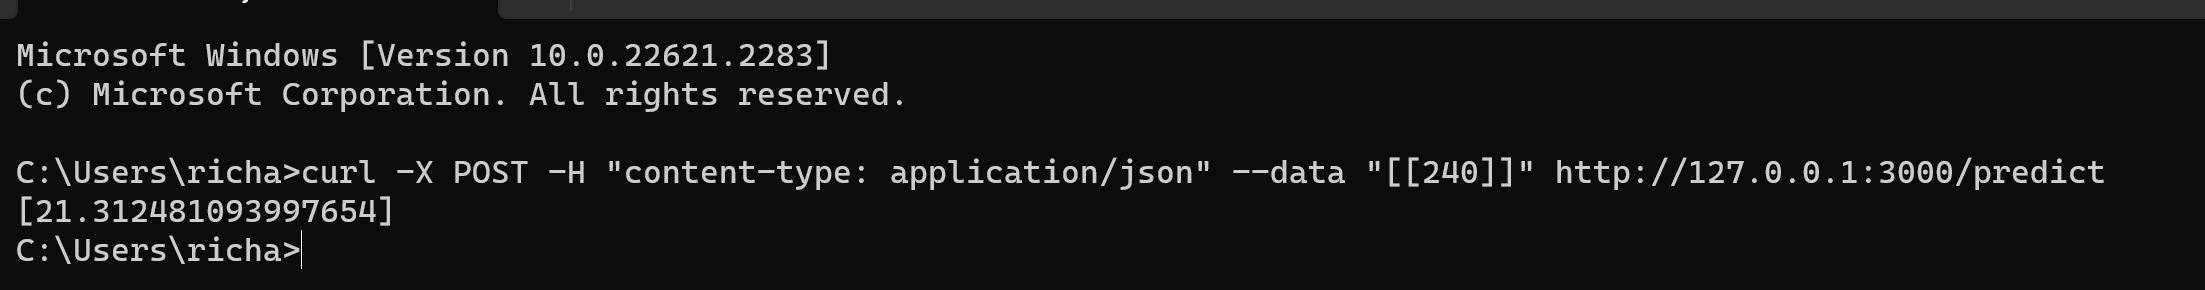

In [ ]:
# view API documentation, go to browser,
# http://127.0.0.1:3000/

# 5.0 Get Predictions

In [34]:
# get_predictions.py
import json
import requests
import numpy as np

endpoint = "http://127.0.0.1:3000/predict"

X_data = "[[240]]"  # rc: seems like even though I specific in api that input should be np array, it is still send over as a string
# with the np.array or list within list inside the string

# if more than one data point to send over, use
X_data = "[[240], [100], [240]]"

response = requests.post(endpoint, 
                         headers={"content-type": "application/json"}, 
                         data=X_data)
print('-'*50)
print(type(response))
print(response)
print(response.text)
print()

--------------------------------------------------
<class 'requests.models.Response'>
<Response [200]>
[21.312481093997654, 31.414774231092515, 21.312481093997654]



# 6.0 Build a Bento
- https://towardsdatascience.com/comprehensive-guide-to-deploying-any-ml-model-as-apis-with-python-and-aws-lambda-b441d257f1ec
- Bento is a term introduced by BentoML that refers to an archive that contains everything needed to make our API work — in a unified format. Inside a Bento, there will be instructions on building a Docker image and the dependencies of our API model.
- <br>
- https://docs.bentoml.org/en/latest/concepts/bento.html
- <br>

### 6.1 bentofile.yaml
https://docs.bentoml.org/en/latest/concepts/bento.html <br>
<br>
We start building the Bento by creating a `bentofile.yaml` file (the name should be the same) in the same directory level as our scripts. It will look like below:

In [ ]:
service: "service.py:svc"  # Same as the argument passed to `bentoml serve`
labels:
   owner: Bex Tuychiev
include:
- "*.py"
python:
   packages:  # Additional pip packages required by the service
   - bentoml==1.0.0
   - numpy==1.22.4
   - pandas==1.4.2
   - scikit_learn==1.1.1
   - xgboost==1.4.2

In [ ]:
# rc version

In [ ]:
service: "service.py:svc"  # Same as the argument passed to `bentoml serve`
labels:
    owner: Richard Chai
    stage: dev    
include:
- "*.py"
python:
    packages:  # Additional pip packages required by the service
    - bentoml==1.1.6
    - numpy==1.26.0
    - pandas==2.1.1
    - scikit_learn==1.3.1

In [ ]:
$> bentoml build

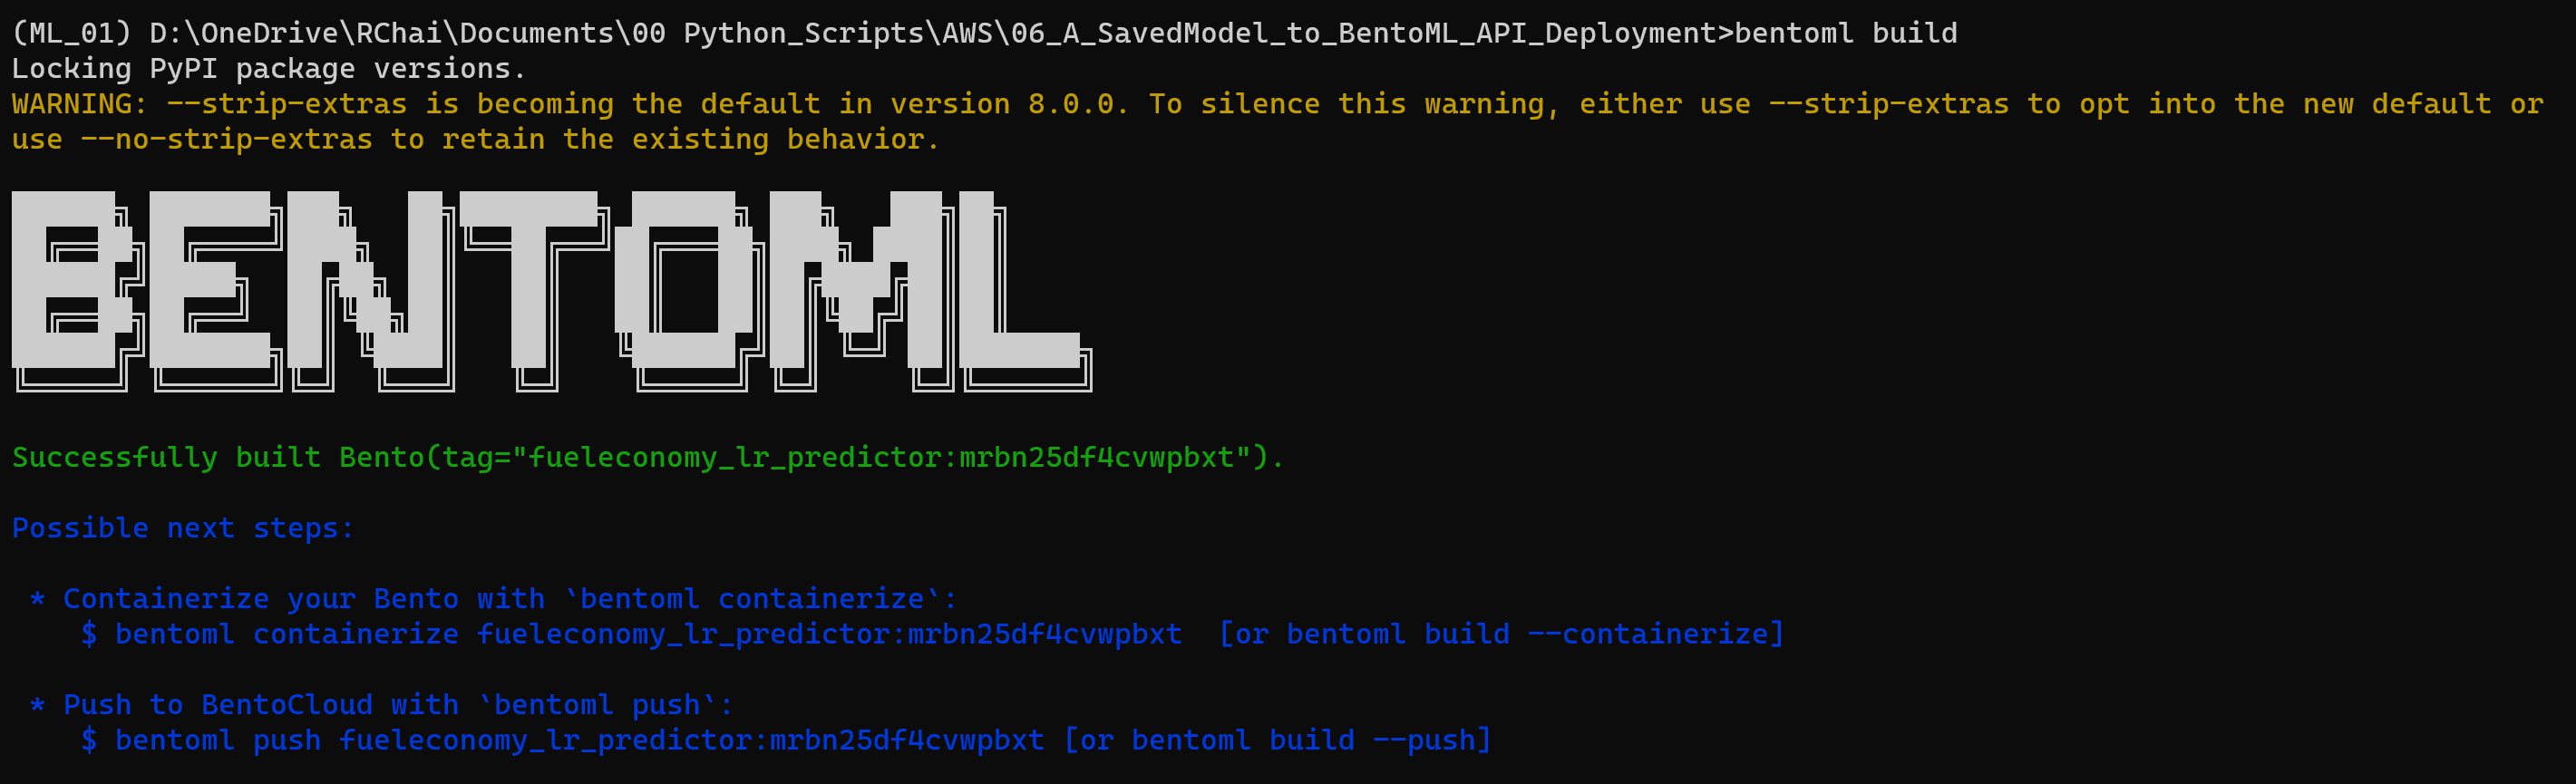

In [41]:
"""
Possible next steps:

 * Containerize your Bento with `bentoml containerize`:
    $ bentoml containerize fueleconomy_lr_predictor:mrbn25df4cvwpbxt  [or bentoml build --containerize]

 * Push to BentoCloud with `bentoml push`:
    $ bentoml push fueleconomy_lr_predictor:mrbn25df4cvwpbxt [or bentoml build --push]
"""

'\nPossible next steps:\n\n * Containerize your Bento with `bentoml containerize`:\n    $ bentoml containerize fueleconomy_lr_predictor:mrbn25df4cvwpbxt  [or bentoml build --containerize]\n\n * Push to BentoCloud with `bentoml push`:\n    $ bentoml push fueleconomy_lr_predictor:mrbn25df4cvwpbxt [or bentoml build --push]\n'

In [ ]:
"""
$> bentoml list


"""

# 7.0 Containerise the Bento

In [42]:
"""
$> bentoml containerize fueleconomy_lr_predictor:mrbn25df4cvwpbxt
"""

'\n$> bentoml containerize fueleconomy_lr_predictor:mrbn25df4cvwpbxt\n'

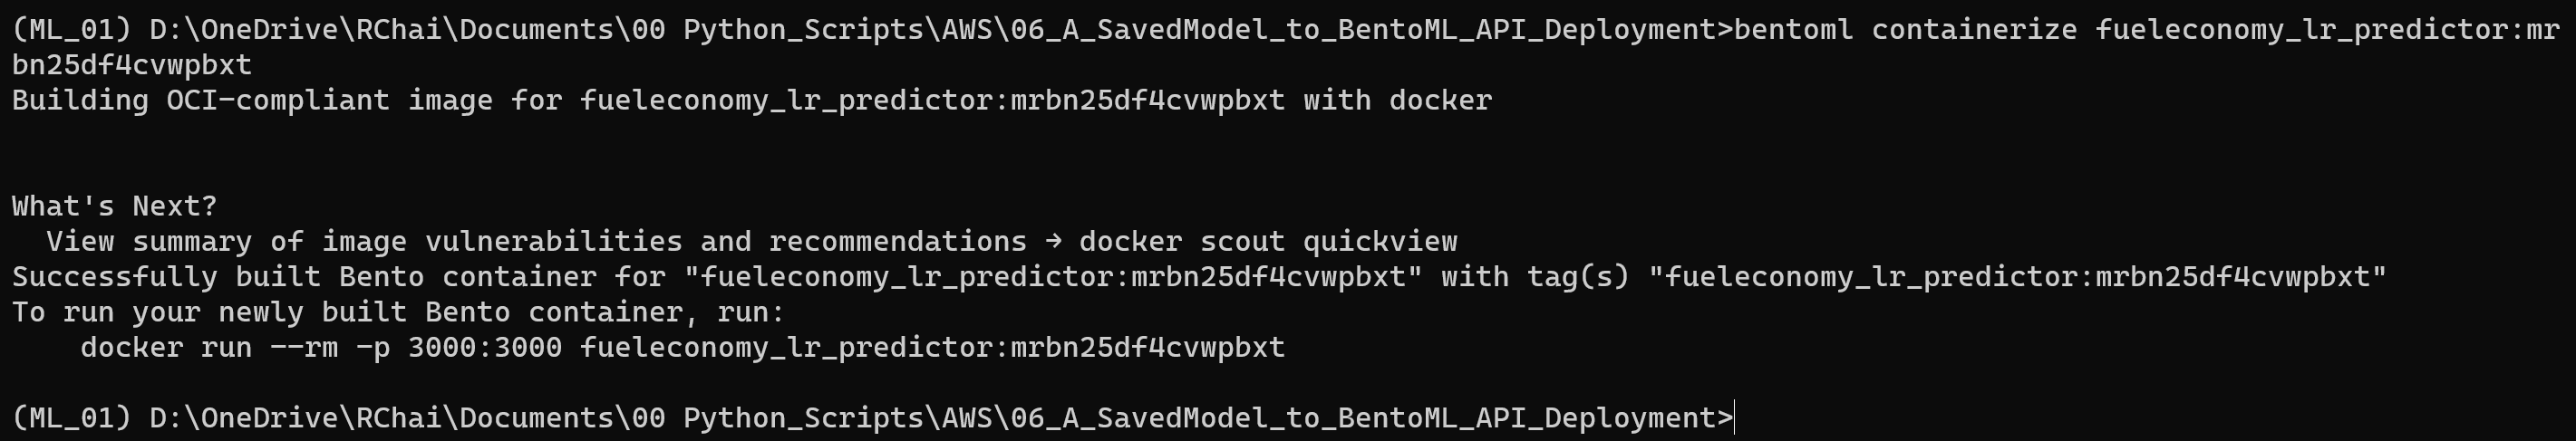

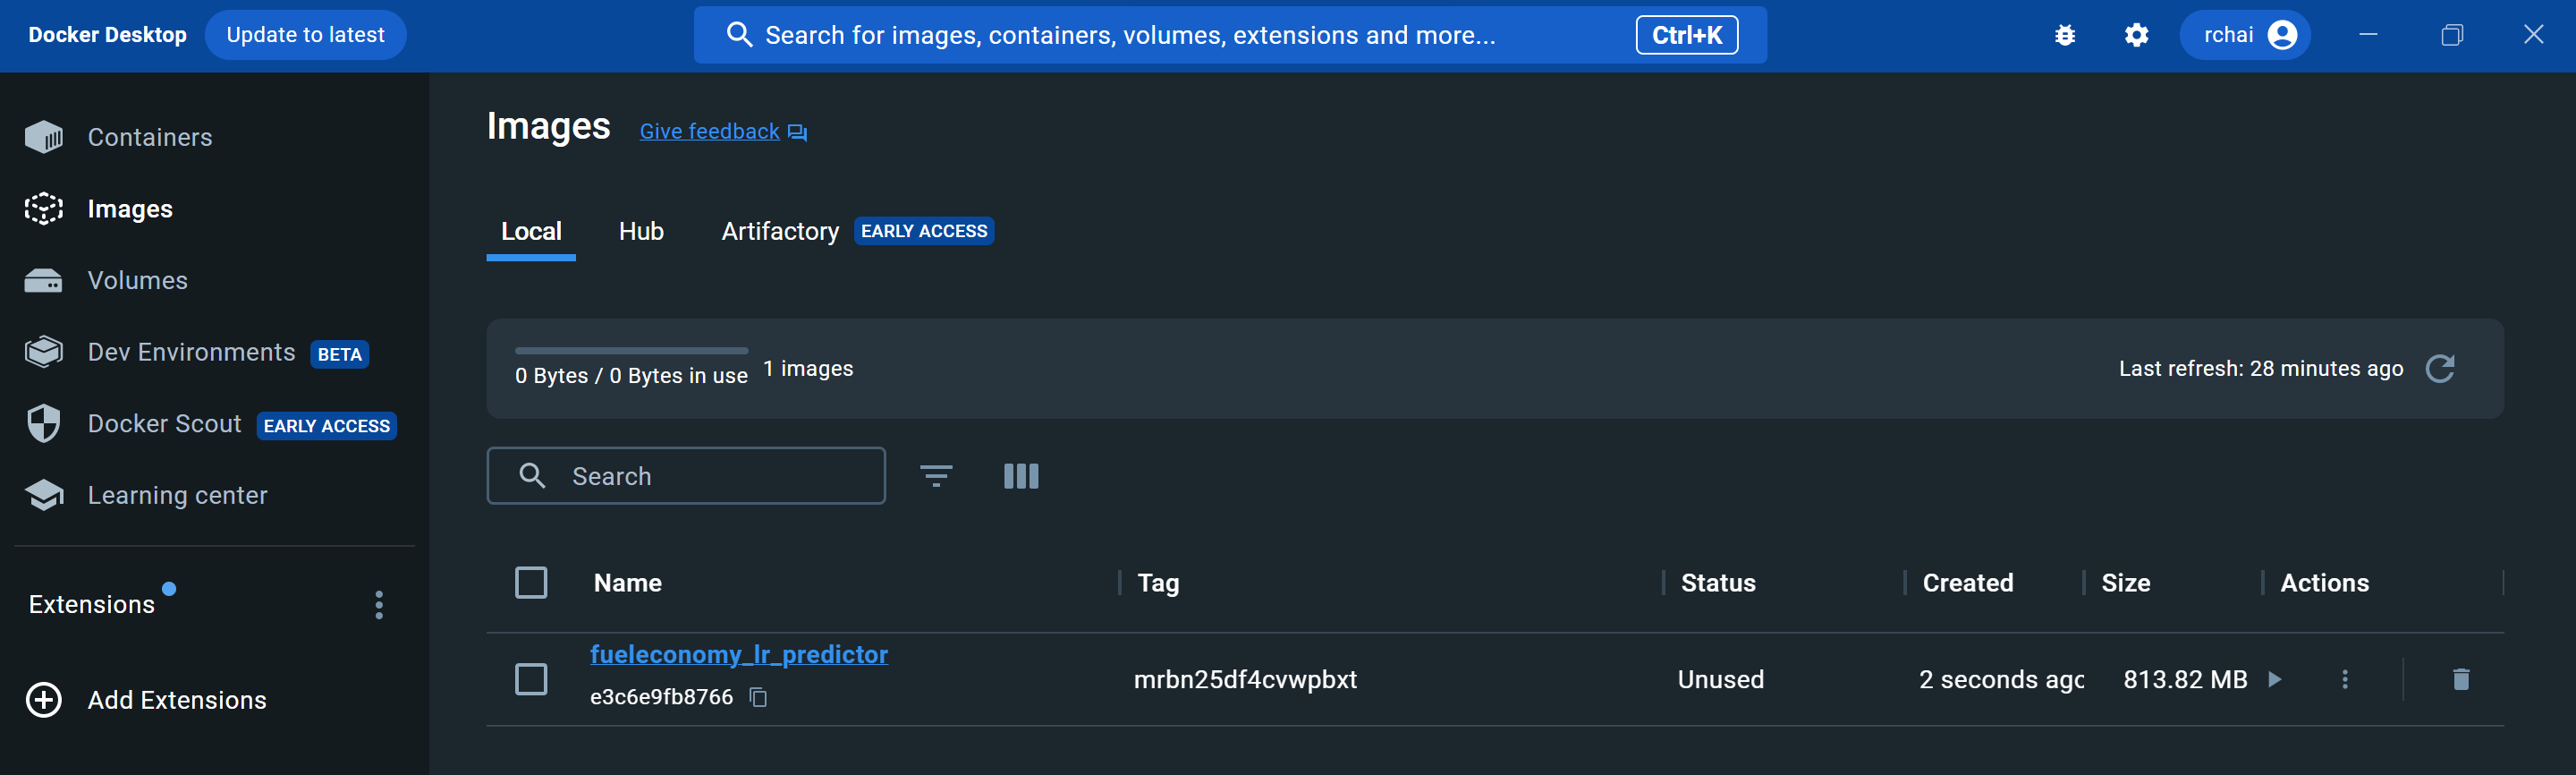

# 8.0 Run the Docker Image as a Container
- https://docs.docker.com/language/golang/run-containers/

Example of exposing port:
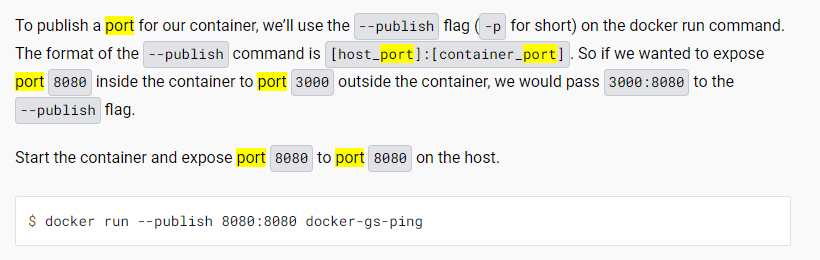

In [ ]:
to test:
    curl -X POST -H "content-type: application/json" --data "[[240]]" http://127.0.0.1:21000/predict

answer: 21.nnnn, it works too!

note: host port is set by docker -p cmd, the internal port 3000 is by bentoml and is set either 
before or during the creation of bento. Unsure if this port 3000 can be changed or not.